# Dataset Generation

This notebook is for generating our initial dataset, we may or may not add additional variables later in our pipeline

## Dataset Description

### Target Dataset:

Near-surface air temperature data in an index format was collected on 24 July 2021 across the Bronx and Manhattan regions of New York City in the United States. The data was collected in the afternoon between 3:00 pm and 4:00 pm. This dataset includes time stamps, traverse points (latitude and longitude) and the corresponding Urban Heat Island (UHI) Index values for 11229 data points. These UHI Index values are the target parameters for your model.

> Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations.

### Feature Datasets:

- European Sentinel-2 optical satellite data
- NASA Landsat optical satellite data
- Building footprints of the Bronx and Manhattan regions
- Detailed local weather dataset of the Bronx and Manhattan regions on 24 July 2021

## Generating The Data

### Set Up

Download libraries not in google collab (can be disregarded if not using collab)

In [ ]:
%pip install stackstac
%pip install pystac-client
%pip install planetary-computer
%pip install odc-stac
%pip install rioxarray

Import libraries

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu
from google.colab import drive
import geopandas as gpd
from shapely.geometry import Point, Polygon
from rasterio.mask import mask

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

#other libs
import pandas as pd
from tqdm import tqdm

Mount google drive, ignore if not using Google Collab:

In [3]:
# mount google drive
drive.mount('/content/drive')
%cd /content/drive/My Drive
!git clone https://github.com/FranciscoLozCoding/cooling_with_code.git
%cd cooling_with_code
!git pull

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
fatal: destination path 'cooling_with_code' already exists and is not an empty directory.
/content/drive/My Drive/cooling_with_code
Already up to date.


### Helper Functions

In [4]:
# Function to calculate the average of pixels within a buffer around each location
def extract_buffer_average(lat, lon, buffer_distance, median, band_name):
    # Create a point for the (lon, lat) location
    point = Point(lon, lat)

    # Create a buffer around the point (in meters)
    buffer = point.buffer(buffer_distance)  # Buffer distance in meters

    # Convert the buffer to GeoJSON format
    geojson = gpd.GeoSeries([buffer]).__geo_interface__

    # Extract the corresponding band data from the median (xarray object)
    band_data = median[band_name]

    # Get the latitude and longitude values from the band data
    latitudes = band_data.coords['latitude'].values
    longitudes = band_data.coords['longitude'].values

    # Create a mask to identify the pixels inside the buffer
    valid_pixels = []

    # Iterate over the latitude and longitude values and check if they fall within the buffer
    for lat_value in latitudes:
        for lon_value in longitudes:
            if buffer.contains(Point(lon_value, lat_value)):
                valid_pixels.append((lat_value, lon_value))  # Collect the valid lat/lon pairs

    # If there are valid pixels inside the buffer, extract their values
    if valid_pixels:
        extracted_values = band_data.sel(latitude=[v[0] for v in valid_pixels],
                                         longitude=[v[1] for v in valid_pixels],
                                         method='nearest').values
        # Remove any NaN values and compute the average
        valid_values = extracted_values[~np.isnan(extracted_values)]

        if len(valid_values) > 0:
            return np.mean(valid_values)  # Return the average of the valid pixels inside the buffer
        else:
            return np.nan  # Return NaN if no valid values inside the buffer
    else:
        return np.nan  # Return NaN if no pixels inside the buffer

### Discover and load the data for analysis

In [5]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [6]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [7]:
# Define the time window
# Define the time window
time_window = "2021-06-01/2021-09-01"

>NOTE: we don't have to match the time window the target variable (UHI) was collected since the features that will be generated using the satellite images don't really change much in a small time window within the same season

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <20%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [8]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 20}},
)

In [9]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 7


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, SWIR). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters.

In [10]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [11]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 5  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

>TODO: Change this to 1 meter per pixel once you are done with everything, so the preceding operations have a resolution of 1 meter per pixel

### Sentinel-2 Bands Summary
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [12]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [13]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 1GB
Dimensions:      (latitude: 2895, longitude: 3340, time: 7)
Coordinates:
  * latitude     (latitude) float64 23kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 27kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 135MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### View RGB (real color) images from the time series
Some of the scenes have clouds. We may want to use a scene from a single date, or create a median composite using all of the data in the time series. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. Finally, the numbering for these scenes starts at ZERO and goes from the top-left across the rows to reach the total number of scenes in the data array shown above.

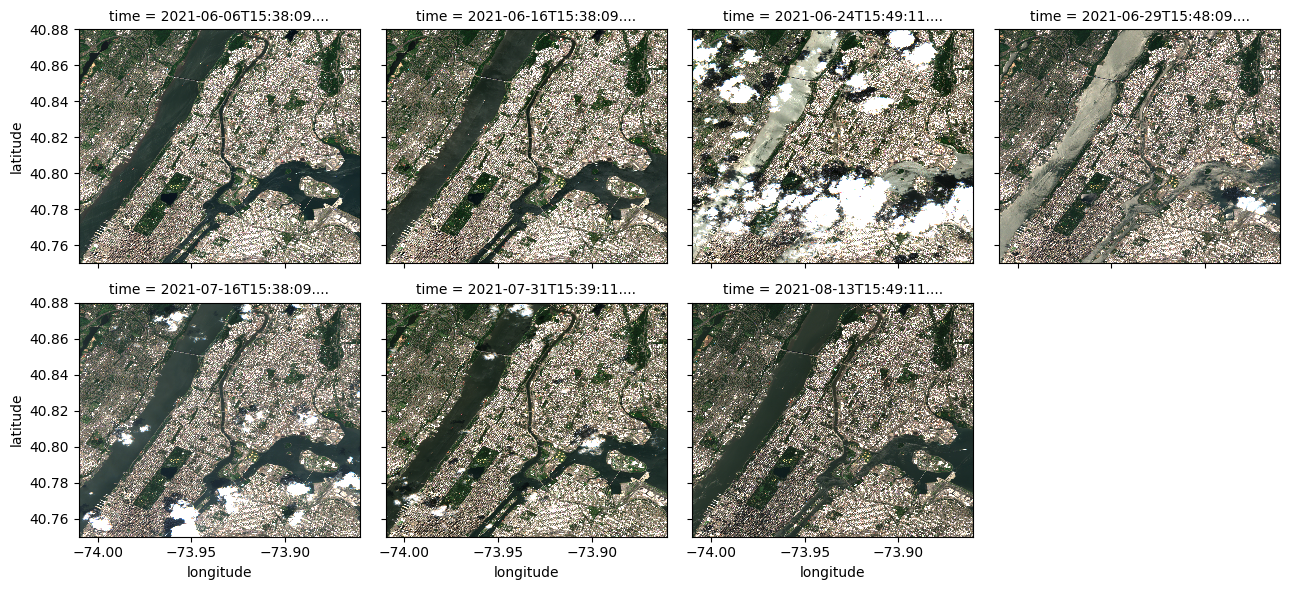

In [14]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<20% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

In [15]:
median = data.median(dim="time").compute()

In [16]:
# Plot an RGB image for the median composite
# This new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

### Creating The Index Variables

#### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [17]:
# Calculate NDVI for the median composite
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

In [18]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

#### Normalized Difference Buildup Index (NDBI)

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [19]:
# Calculate NDBI for the median composite
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

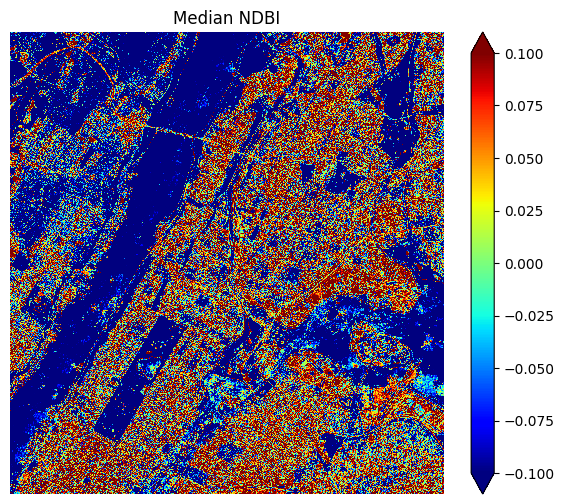

In [20]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

#### Normalized Difference Water Index (NDWI)

The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [21]:
# Calculate NDWI for the median composite
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

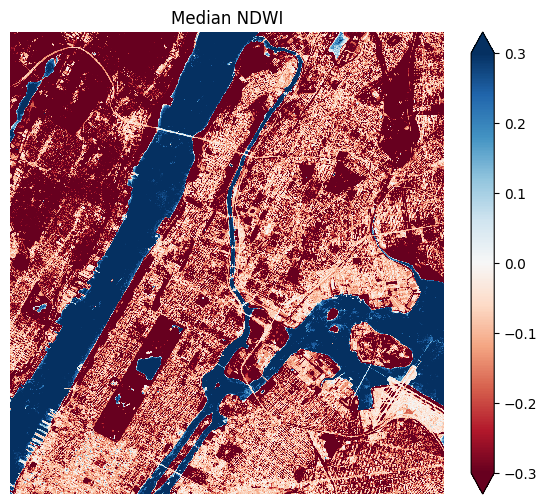

In [22]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

#### Shadow Index (SI)

The Shadow Index (SI) is an index used in remote sensing to detect and assess shadowed areas in an image. Shadows are created when objects (e.g., buildings, trees, or terrain) block light, and they often appear darker in satellite or aerial imagery. The Shadow Index helps in identifying areas where shadows occur. The range of the SI typically spans from -1 to +1. Negative values indicate shadows (lower reflectance in both the red and SWIR bands). Positive values indicate illuminated areas or non-shadowed surfaces.

In [23]:
# Calculate SI for the median composite
si_median = (median.B11 - median.B04)/(median.B11 + median.B04)

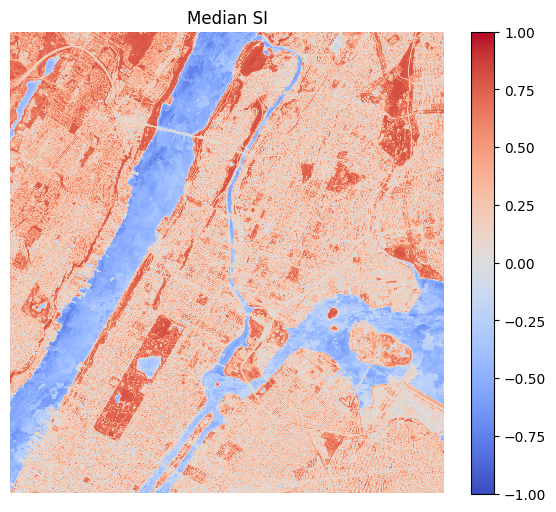

In [24]:
fig, ax = plt.subplots(figsize=(7,6))
si_median.plot.imshow(vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Median SI")
plt.axis('off')
plt.show()

#### Normalized Difference Moisture Index (NDMI)

The normalized difference moisture Index (NDMI) is used to determine vegetation water content and monitor droughts. The value range of the NDMI is -1 to 1. Negative values of NDMI (values approaching -1) correspond to barren soil. Values around zero (-0.2 to 0.4) generally correspond to water stress. High, positive values represent high canopy without water stress (approximately 0.4 to 1).

In [25]:
# Calculate NDMI for the median composite
ndmi_median = (median.B08 - median.B11)/(median.B08 + median.B11)

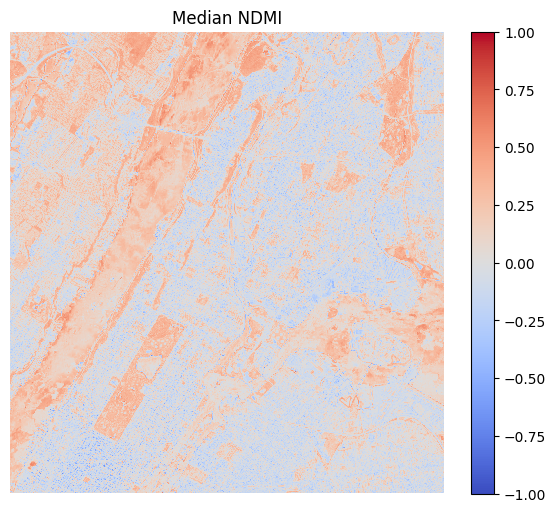

In [26]:
fig, ax = plt.subplots(figsize=(7,6))
ndmi_median.plot.imshow(vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Median NDMI")
plt.axis('off')
plt.show()

#### Normalized Pigment Chlorophyll Ratio Index (NPCRI)

The Normalized Pigment Chlorophyll Ratio Index (NPCRI) is a remote sensing index designed to estimate the chlorophyll content in vegetation. Chlorophyll is a key pigment in plants that is essential for photosynthesis, and its concentration is directly related to plant health and productivity. Being that photosynthesis reduces heat, this might be useful to determine plant productivity in reducing heat. Values close to 1: Indicate high chlorophyll content (healthy vegetation with strong photosynthetic activity).
Values closer to -1: Indicate low chlorophyll content (stressed or unhealthy vegetation).

In [27]:
# Calculate NPCRI for the median composite
npcri_median = (median.B04 - median.B02) / (median.B04 + median.B02)

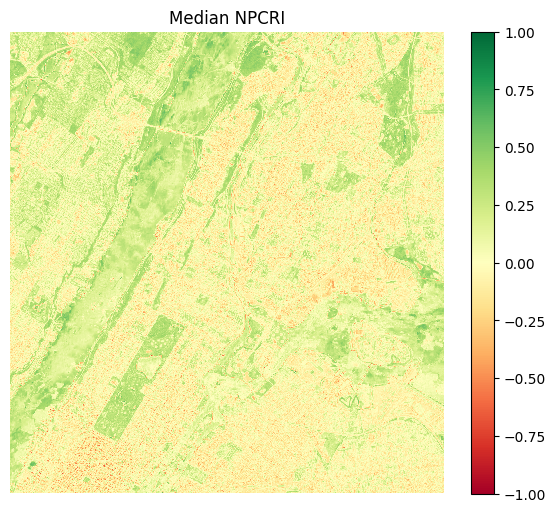

In [28]:
fig, ax = plt.subplots(figsize=(7,6))
ndmi_median.plot.imshow(vmin=-1, vmax=1, cmap="RdYlGn")
plt.title("Median NPCRI")
plt.axis('off')
plt.show()

#### Coastal Aerosol

Coastal aerosol refers to aerosol particles (tiny solid or liquid particles suspended in the atmosphere) that are found in or around coastal regions. These aerosols are typically composed of a variety of substances, including salt, dust, organic compounds, and pollutants. Coastal aerosols have a significant influence on local weather, climate, air quality, and ocean ecosystems.

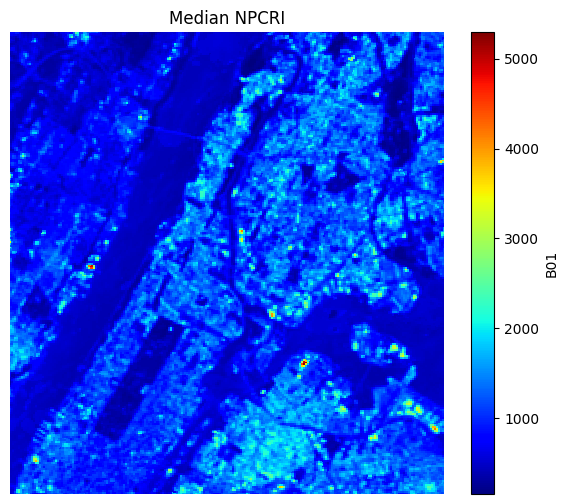

In [29]:
fig, ax = plt.subplots(figsize=(7,6))
median.B01.plot.imshow(cmap="jet")
plt.title("Median NPCRI")
plt.axis('off')
plt.show()

### Add indices to Xarray

In [30]:
# Add indices to the dataset
median['NDVI'] = (['latitude', 'longitude'], ndvi_median.values)
median['NDBI'] = (['latitude', 'longitude'], ndbi_median.values)
median['NDWI'] = (['latitude', 'longitude'], ndwi_median.values)
median['SI'] = (['latitude', 'longitude'], si_median.values)
median['NDMI'] = (['latitude', 'longitude'], ndmi_median.values)
median['NPCRI'] = (['latitude', 'longitude'], npcri_median.values)
median['Coastal_Aerosol'] = (['latitude', 'longitude'], median.B01.values)

In [31]:
median

<xarray.Dataset> Size: 1GB
Dimensions:          (latitude: 2895, longitude: 3340)
Coordinates:
  * latitude         (latitude) float64 23kB 40.88 40.88 40.88 ... 40.75 40.75
  * longitude        (longitude) float64 27kB -74.01 -74.01 ... -73.86 -73.86
    spatial_ref      int32 4B 4326
Data variables: (12/18)
    B01              (latitude, longitude) float64 77MB 705.0 705.0 ... 1.19e+03
    B02              (latitude, longitude) float64 77MB 675.0 ... 1.322e+03
    B03              (latitude, longitude) float64 77MB 820.0 ... 1.446e+03
    B04              (latitude, longitude) float64 77MB 817.0 ... 1.504e+03
    B05              (latitude, longitude) float64 77MB 999.0 ... 1.632e+03
    B06              (latitude, longitude) float64 77MB 2.135e+03 ... 1.722e+03
    ...               ...
    NDBI             (latitude, longitude) float64 77MB -0.02278 ... 0.07312
    NDWI             (latitude, longitude) float64 77MB -0.3939 ... -0.1194
    SI               (latitude, longitude) float64 77MB 0.3761 0.3761 ... 0.1718
    NDMI             (latitude, longitude) float64 77MB 0.02278 ... -0.07312
    NPCRI            (latitude, longitude) float64 77MB 0.09517 ... 0.0644
    Coastal_Aerosol  (latitude, longitude) float64 77MB 705.0 705.0 ... 1.19e+03

### Combating Spacial Autocorrelation & Combing Indices with Target Variable (UHI Index)

To combat spacial autocorrelation we will create different bufferzones (50m, 100m, 150m).

In [32]:
#csv path for target variable
csv_path = "data/Training_data_uhi_index.csv"

# Read the Excel file using pandas
uhi_df = pd.read_csv(csv_path)
uhi = uhi_df['UHI Index'].values
latitudes = uhi_df['Latitude'].values
longitudes = uhi_df['Longitude'].values
datetimes = uhi_df['datetime'].values

buffer_distance = 50  # Buffer distance in meters (adjustable)

# Initialize a list for storing the average values for each location and band
ndvi_values = []
ndbi_values = []
ndwi_values = []
si_values = []
ndmi_values = []
npcri_values = []
ca_values = []

# Iterate over latitudes and longitudes
for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Extracting average values"):
    ndvi_value = extract_buffer_average(lat, lon, buffer_distance, median, 'NDVI')
    ndvi_values.append(ndvi_value)
    ndbi_value = extract_buffer_average(lat, lon, buffer_distance, median, 'NDBI')
    ndbi_values.append(ndbi_value)
    ndwi_value = extract_buffer_average(lat, lon, buffer_distance, median, 'NDWI')
    ndwi_values.append(ndwi_value)
    si_value = extract_buffer_average(lat, lon, buffer_distance, median, 'SI')
    si_values.append(si_value)
    ndmi_value = extract_buffer_average(lat, lon, buffer_distance, median, 'NDMI')
    ndmi_values.append(ndmi_value)
    npcri_value = extract_buffer_average(lat, lon, buffer_distance, median, 'NPCRI')
    npcri_values.append(npcri_value)
    ca_value = extract_buffer_average(lat, lon, buffer_distance, median, 'Coastal_Aerosol')
    ca_values.append(ca_value)

# create a DataFrame with the average values
fifty_df = pd.DataFrame({
    'Longitude': longitudes,
    'Latitude': latitudes,
    'datetime': datetimes,
    'UHI': uhi,
    'NDVI': ndvi_values,
    'NDBI': ndbi_values,
    'NDWI': ndwi_values,
    'SI': si_values,
    'NDMI': ndmi_values,
    'NPCRI': npcri_values,
    'Coastal_Aerosol': ca_values
})

Extracting average values:   0%|          | 0/11229 [06:19<?, ?it/s]


MemoryError: Unable to allocate 680. TiB for an array with shape (9669300, 9669300) and data type float64

### Removing duplicates
Identical or duplicate entries are removed based on specific columns. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [ ]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['NDBI','NDWI','SI','NDMI','NDVI', 'NPCRI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    first_df[col] = first_df[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
second_df = first_df.drop_duplicates(subset=columns_to_check, keep='first')
second_df.head()

### Building Footprints

## Reference

- Description: Ground temperature data over New York City on July 24, 2021 (CSV format)
Contributors: Climate, Adaptation, Planning, Analytics (CAPA) Strategies
Data Host: Center for Open Science - https://www.cos.io
Terms of Use: https://github.com/CenterForOpenScience/cos.io/blob/master/TERMS_OF_USE.md
License: Apache 2.0 > https://github.com/CenterForOpenScience/cos.io/blob/master/LICENSE
Satellite Data (Sentinel-2 Sample Output)

- Description: Copernicus Sentinel-2 sample data from 2021 obtained from the Microsoft Planetary Computer (TIFF format)
Contributors: European Space Agency (ESA), Microsoft
Data Host: Microsoft Planetary Computer - https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a
Terms of Use: https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice
License: https://creativecommons.org/licenses/by-sa/3.0/igo/
Building Footprint Data

- Description: Building footprint polygons over the data challenge region of interest (KML format)
Contributors: Open Data Team at the NYC Office of Technology and Innovation (OTI) - New York City Open Data Project
Data Host: https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
Terms of Use: https://www.nyc.gov/html/data/terms.html and https://www.nyc.gov/home/terms-of-use.page
License: https://github.com/CityOfNewYork/nyc-geo-metadata#Apache-2.0-1-ov-file
Weather Data

- Description: Detailed weather data collected every 5 minutes at two locations (Bronx and Manhattan). Includes surface air temperature (2-meters), relative humidity, average wind speed, wind direction, and solar flux.
Contributors: Contributors: New York State Mesonet
Data Host: https://nysmesonet.org/
Terms of Use: https://nysmesonet.org/about/data
License: https://nysmesonet.org/documents/NYS_Mesonet_Data_Access_Policy.pdf